Valid entries after cleaning: 12454
Random Forest Model
Mean Squared Error: 73553.62519606164
R-squared: 0.6521762765087411
Mean Absolute Percentage Error: 1.2972078347551708


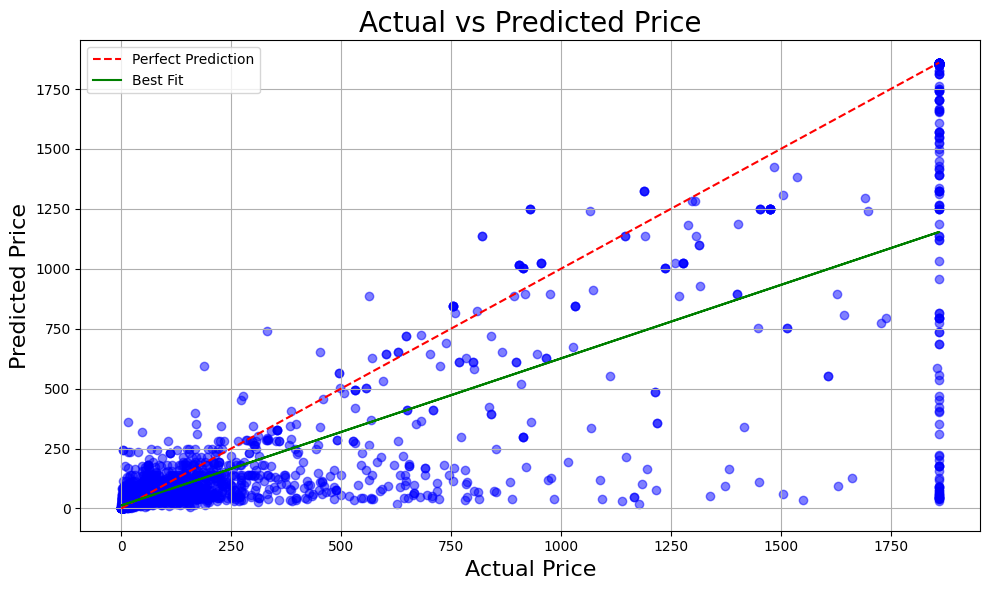

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split  # For splitting data into training and test sets
from sklearn.ensemble import RandomForestRegressor  # The regression model we'll use
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error  # For model evaluation
from sklearn.preprocessing import LabelEncoder  # For converting categorical data to numeric
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text descriptions to numeric features
from sklearn.preprocessing import StandardScaler  # For scaling numeric features
import matplotlib.pyplot as plt
import numpy as np

# Load dataset from Excel file
filename = 'nsn dataset.xlsx'
data = pd.read_excel(filename)

# Data cleaning: Convert Price column to numeric format and handle invalid values
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')  # Convert prices to numbers, invalid entries become NaN
data = data.dropna(subset=['Price'])  # Remove rows with missing price values
data = data[data['Price'] > 0]  # Keep only rows with positive prices

# Print the number of valid entries remaining after cleaning
print(f"Valid entries after cleaning: {len(data)}")

# Handle outliers by capping prices at the 95th percentile
price_cap = data['Price'].quantile(0.95)  # Calculate value at 95th percentile
data['Price'] = np.where(data['Price'] > price_cap, price_cap, data['Price'])  # Cap prices exceeding this value

# Apply log transformation to price data to reduce skewness (common for price data)
data['Log_Price'] = np.log1p(data['Price'])  # log1p = log(1+x) to handle zero values safely

# Convert categorical UI column to numerical using Label Encoding
label_encoder = LabelEncoder()  # Initialize the encoder
data['UI_encoded'] = label_encoder.fit_transform(data['UI'].astype(str))  # Transform text UI values to integers

# Extract features from text descriptions using TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=100)  # Initialize TF-IDF with max 100 features
desc_tfidf = tfidf.fit_transform(data['Description'].astype(str))  # Convert text to numeric features
desc_df = pd.DataFrame(desc_tfidf.toarray(), columns=tfidf.get_feature_names_out())  # Convert to DataFrame

# Combine all features into a single feature matrix
X = desc_df.copy()  # Start with TF-IDF features from descriptions
X['UI_encoded'] = data['UI_encoded']  # Add the encoded UI column
y = data['Log_Price']  # Set target variable as log-transformed price

# Standardize features (mean=0, std=1) to improve model performance
scaler = StandardScaler()  # Initialize the scaler
X_scaled = scaler.fit_transform(X)  # Scale all features

# Split data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Create and configure the Random Forest Regressor model
model = RandomForestRegressor(
    n_estimators=200,       # Number of trees in the forest (more trees = better performance)
    max_depth=20,           # Maximum depth of each tree (limits complexity)
    min_samples_leaf=2,     # Minimum samples at leaf nodes (prevents overfitting)
    n_jobs=-1,              # Use all CPU cores for faster training
    random_state=42         # Set seed for reproducible results
)
model.fit(X_train, y_train)  # Train the model on training data

# Make predictions on the test set (still in log scale)
y_pred_log = model.predict(X_test)

# Convert predictions back to original price scale
y_pred = np.expm1(y_pred_log)  # Reverse log transformation with expm1 (e^x - 1)
y_test_actual = np.expm1(y_test)  # Also convert actual test values back to original scale

# Calculate model performance metrics
mse = mean_squared_error(y_test_actual, y_pred)  # Mean Squared Error (lower is better)
r2 = r2_score(y_test_actual, y_pred)  # R-squared: variance explained (0-1, higher is better)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)  # Mean Absolute % Error (lower is better)

# Print model evaluation results
print("Random Forest Model")
print("Mean Squared Error:", mse) # Average squared difference between the actual prices
print("R-squared:", r2)
print("Mean Absolute Percentage Error:", mape) # indicating better average percentage difference between the actual and predicted prices

# Create visualization of model performance (actual vs. predicted)
plt.figure(figsize=(10, 6))  # Set figure size (width, height in inches)
plt.scatter(y_test_actual, y_pred, color='blue', alpha=0.5)  # Plot data points with transparency
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()],
         'r--', label='Perfect Prediction')  # Add red dashed diagonal line for perfect predictions
z = np.polyfit(y_test_actual, y_pred, 1)  # Calculate best-fit line coefficients
p = np.poly1d(z)  # Create polynomial function from coefficients
plt.plot(y_test_actual, p(y_test_actual), color='green', label='Best Fit')  # Add green best-fit line

# Format the plot with labels and styling
plt.xlabel('Actual Price', fontsize=16)  # X-axis label
plt.ylabel('Predicted Price', fontsize=16)  # Y-axis label
plt.title('Actual vs Predicted Price', fontsize=20)  # Plot title
plt.legend()  # Add legend based on labels
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust spacing for better appearance
plt.show()